# Advanced PSF modeling



In [1]:
import autophot as ap
import numpy as np
import torch
from astropy.io import fits
import matplotlib.pyplot as plt
from time import time
%matplotlib inline


# PSF modeling without stars

Can it be done? Let's see!

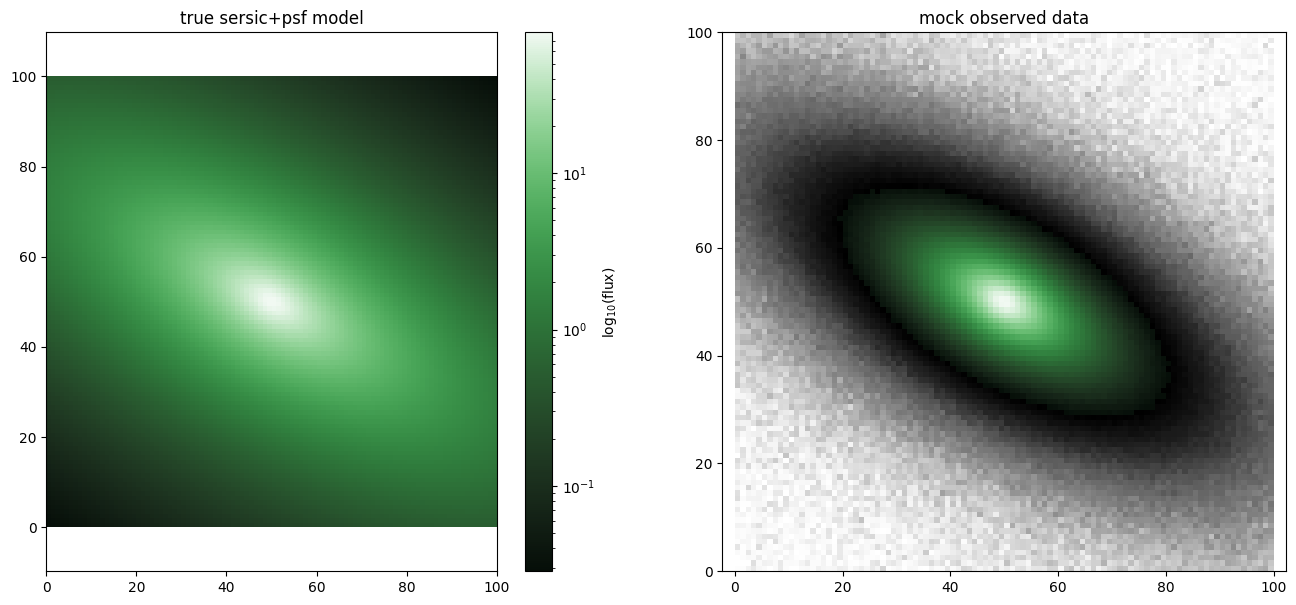

In [2]:
# Lets make some data that we need to fit

true_psf = ap.utils.initialize.moffat_psf(
    2., # n                                !!!!! Take note, we want to get n = 2. !!!!!! 
    3., # Rd                               !!!!! Take note, we want to get Rd = 3.!!!!!!
    51, # pixels
    1.  # pixelscale
)

target = ap.image.Target_Image(
    data = torch.zeros(100,100), 
    pixelscale = 1.,
    psf = true_psf,
)

true_model = ap.models.AutoPhot_Model(
    name = "true model",
    model_type = "sersic galaxy model",
    target = target,
    parameters = {
        "center": [50,50],
        "q": 0.4,
        "PA": np.pi/3,
        "n": 2,
        "Re": 25,
        "Ie": 1,
    },
    psf_mode = "full",
)

# use the true model to make some data
sample = true_model()
torch.manual_seed(1618033988)
target.data = sample.data + torch.normal(torch.zeros_like(sample.data), 0.1)

fig, ax = plt.subplots(1,2, figsize = (16,7))
ap.plots.model_image(fig, ax[0], true_model)
ap.plots.target_image(fig, ax[1], target)
ax[0].set_title("true sersic+psf model")
ax[1].set_title("mock observed data")
plt.show()

In [3]:
# Now we will try and fit the data

# Here we set up a sersic model for the galaxy
galaxy_model = ap.models.AutoPhot_Model(
    name = "galaxy model",
    model_type = "sersic galaxy model",
    target = target,
    psf_mode = "full",
)

# Here we create a moffat auxiliary model for the PSF. Auxiliary models don't actually contribute 
# light to the image, they modify the behaviour of other models in some way that requires expanding 
# the parameters in fitting.
psf_model = ap.models.AutoPhot_Model(
    name = "psf model",
    model_type = "moffat circular psf aux model",
    target = target,
    parameters = {
        "n*": 1., # True value is 2.
        "Rd*": 2., # True value is 3.
    }
)

# Here we bind the PSF model to the galaxy model, this will add the psf_model parameters to the galaxy_model
# object since it now depends on those.
galaxy_model.set_aux_psf(psf_model)

# Let AutoPhot determine its own intial parameters, so it has to start with whatever it decides automatically, 
# just like a real fit.
galaxy_model.initialize()

result = ap.fit.LM(galaxy_model, verbose = 1).fit()
print(result.message)

L: 1.0
---------init---------
LM loss: 11.31101220345678
L: 1.0
---------iter---------
LM loss: 8.787586570055984
accept
L: 0.1111111111111111
---------iter---------
LM loss: 0.13779913300710764
accept
L: 0.012345679012345678
---------iter---------
LM loss: 0.03956503384836573
accept
L: 0.0013717421124828531
---------iter---------
LM loss: 0.010638274704073223
accept
L: 0.00015241579027587256
---------iter---------
LM loss: 0.00998394437855839
accept
L: 1.6935087808430286e-05
---------iter---------
LM loss: 0.009983888822608016
accept
L: 1.8816764231589206e-06
---------iter---------
LM loss: 0.009983888822569202
accept
success


In [4]:
print("fitted n for moffat PSF: ", galaxy_model["n*"].value.item(), "we were hoping to get 2!")
print("fitted Rd for moffat PSF: ", galaxy_model["Rd*"].value.item(), "we were hoping to get 3!")

fitted n for moffat PSF:  1.9688963503310952 we were hoping to get 2!
fitted Rd for moffat PSF:  2.978369891715757 we were hoping to get 3!


This is truly remarkable! With no stars available we were still able to extract an accurate PSF from the image! To be fair, this example is essentially perfect for this kind of fitting and we knew the true model types (sersic and moffat) from the start. Still, this is a powerful capability in certain scenarios. For many applications (e.g. weak lensing) it is essential to get the absolute best PSF model possible. Here we have shown that not only stars, but galaxies in the field can be useful tools for measuring the PSF!

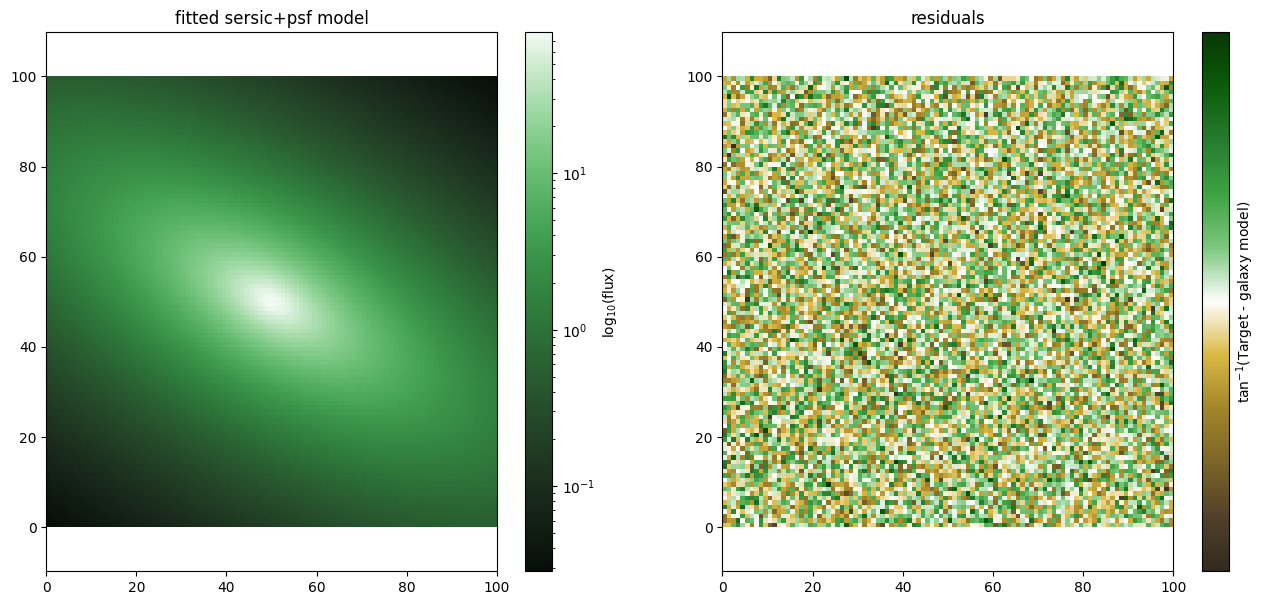

In [5]:
fig, ax = plt.subplots(1,2, figsize = (16,7))
ap.plots.model_image(fig, ax[0], galaxy_model)
ap.plots.residual_image(fig, ax[1], galaxy_model)
ax[0].set_title("fitted sersic+psf model")
ax[1].set_title("residuals")
plt.show()

There are regions of parameter space that are degenerate and so even in this idealized scenario the PSF model can get stuck. If you rerun the notebook with different random number seeds for pytorch you may find some where the optimizer "fails by immobility" this is when it get's stuck in the parameter space and can't find any way to improve the likelihood. In fact most of these "fail" fits do return really good values for the PSF model, so keep in mind that the "fail" flag only means the possibility of a truly failed fit. Unfortunatly, detecting convergence is hard.